# Question Answering with Langchain and OpenAI

<a target="_blank" href="https://colab.research.google.com/github/elastic/elasticsearch-labs/blob/main/notebooks/generative-ai/question-answering.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This interactive notebook uses Langchain to split fictional workplace documents into passages and uses OpenAI to transform these passages into embeddings and store them into Elasticsearch.


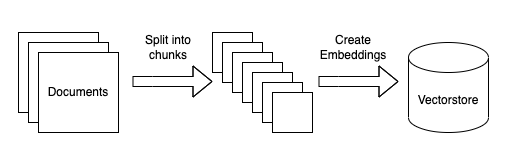

Then when we ask a question, we retrieve the relevant passages from the vector store and use langchain and OpenAI to provide a summary for the question.

## Install packages and import modules


In [ ]:
# install packages

!python3 -m pip install -qU langchain openai elasticsearch tiktoken

# import modules
from getpass import getpass
from langchain.vectorstores import ElasticsearchStore
from langchain.embeddings.openai import OpenAIEmbeddings
from urllib.request import urlopen
from langchain.text_splitter import CharacterTextSplitter
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
import json

## Connect to Elasticsearch

ℹ️ We're using an Elastic Cloud deployment of Elasticsearch for this notebook. If you don't have an Elastic Cloud deployment, sign up [here](https://cloud.elastic.co/registration?fromURI=%2Fhome) for a free trial. 

We'll use the **Cloud ID** to identify our deployment, because we are using Elastic Cloud deployment. To find the Cloud ID for your deployment, go to https://cloud.elastic.co/deployments and select your deployment.


We will use [ElasticsearchStore](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.elasticsearch.ElasticsearchStore.html) to connect to our elastic cloud deployment. This would help create and index data easily. In the ElasticsearchStore instance, will set embedding to [OpenAIEmbeddings](https://api.python.langchain.com/en/latest/embeddings/langchain.embeddings.openai.OpenAIEmbeddings.html) to embed the texts and elasticsearch index name that will be used in this example.

In [52]:
# set elastic cloud id and password

CLOUD_ID = getpass("Elastic deployment Cloud ID")
CLOUD_USERNAME = "elastic"
CLOUD_PASSWORD = getpass("Elastic deployment Password")

# set OpenAI API key
OPENAI_API_KEY = getpass("OpenAI API key")

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY)

vector_store = ElasticsearchStore(es_cloud_id=CLOUD_ID, es_user=CLOUD_USERNAME, es_password=CLOUD_PASSWORD,
            index_name= "workplace_index",
            embedding=embeddings
        )


## Download the dataset 

Let's download the sample dataset and deserialize the document.

In [ ]:
url = "https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/example-apps/workplace-search/example-data/data.json"

response = urlopen(url)

workplace_docs = json.loads(response.read())


### Split Documents into Passages

We’ll chunk documents into passages in order to improve the retrieval specificity and to ensure that we can provide multiple passages within the context window of the final question answering prompt.

Here we are chunking documents into 800 token passages with an overlap of 400 tokens.

Here we are using a simple splitter but Langchain offers more advanced splitters to reduce the chance of context being lost.

In [ ]:
metadata = []
content = []

for doc in workplace_docs:
  content.append(doc["content"])
  metadata.append({
      "name": doc["name"],
      "summary": doc["summary"]
  })

text_splitter = CharacterTextSplitter(chunk_size=800, chunk_overlap=400)
docs = text_splitter.create_documents(content, metadatas=metadata)

## Index data into elasticsearch

Now that we have split each document into the chunk size of 800, we will now index data to elasticsearch using [ElasticsearchStore.from_documents](https://api.python.langchain.com/en/latest/vectorstores/langchain.vectorstores.elasticsearch.ElasticsearchStore.html#langchain.vectorstores.elasticsearch.ElasticsearchStore.from_documents).

We will use Cloud ID,  Password and Index name values set in the `Create cloud deployment` step.

In [ ]:
documents = vector_store.from_documents(
    docs, embeddings, es_cloud_id=CLOUD_ID, es_user=CLOUD_USERNAME, es_password=CLOUD_PASSWORD, index_name="workplace_index"
)

## Asking a question
Now that we have the passages stored in Elasticsearch, we can now ask a question to get the relevant passages.

In [36]:
retriever = vector_store.as_retriever()

llm = OpenAI(openai_api_key=OPENAI_API_KEY)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

ans = qa({"query": "what is the nasa sales team?"})

print("---- Answer ----")
print(ans["result"])
print("---- Sources ----")
for doc in ans["source_documents"]:
  print(doc.metadata["name"])
  print(doc.page_content)

---- Answer ----
 The NASA sales team is the North America South America regional sales team, led by the Area Vice-Presidents Laura Martinez and Gary Johnson.
---- Sources ----
Sales Organization Overview
Our sales organization is structured to effectively serve our customers and achieve our business objectives across multiple regions. The organization is divided into the following main regions:

The Americas: This region includes the United States, Canada, Mexico, as well as Central and South America. The North America South America region (NASA) has two Area Vice-Presidents: Laura Martinez is the Area Vice-President of North America, and Gary Johnson is the Area Vice-President of South America.
Sales Organization Overview
Our sales organization is structured to effectively serve our customers and achieve our business objectives across multiple regions. The organization is divided into the following main regions:

The Americas: This region includes the United States, Canada, Mexico, a